In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import os
import cv2
import glob
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## Making lists of dataset files

In [3]:
train_jsons = sorted(glob.glob('/content/drive/MyDrive/sia/format/Objects/train/json/*'))

## Loading training meta data (json) 

In [4]:
train_meta = []
for j in train_jsons:
    json_obj = json.load(open(j))
    # json_obj['features']
    for f in json_obj['features']:
        # geometry
        geo_coord = f['geometry']['coordinates']
        geo_type = f['geometry']['type']
        # properties
        object_imcoords = f['properties']['object_imcoords']
        object_angle = f['properties']['object_angle']
        building_imcoords = f['properties']['building_imcoords']
        road_imcoords = f['properties']['road_imcoords'] 
        image_id = f['properties']['image_id'] # 영상 ID
        ingest_time = f['properties']['ingest_time'] # 	영상 생성 시간
        type_id = f['properties']['type_id'] # 정수 (1~N), 클래스 id
        type_name = f['properties']['type_name'] # 클래스 이름

        # add to list
        train_meta.append([image_id, type_id, type_name, geo_coord, geo_type, object_angle,
                           object_imcoords, building_imcoords, road_imcoords, ingest_time])
# Make dataframe
df_train = pd.DataFrame(train_meta,
                        columns = ['image_id','type_id','type_name','geo_coord','geo_type','object_angle',
                                   'object_imcoords','building_imcoords','road_imcoords','ingest_time'])

In [5]:
df_train.head(10)

,image_id,type_id,type_name,geo_coord,geo_type,object_angle,object_imcoords,building_imcoords,road_imcoords,ingest_time
0,OBJ00013_PS3_K3_NIA0078.png,3,civilian aircraft,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,6.283185,"469.1820926230315,473.2955533775398,561.654399...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
1,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.547254,"993.6889260747658,339.4410959499382,988.810925...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
2,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.647914,"988.7026551987746,331.54721860229455,984.09007...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
3,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,0.607917,"935.9948592758786,141.9939151216178,940.820433...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
4,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.612815,"873.1437932557097,45.11725293949537,871.080320...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
5,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.588400,"869.803319942681,46.30678680115171,867.1144048...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
6,OBJ00013_PS3_K3_NIA0078.png,5,small car,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,3.564912,"865.0319303000208,48.87218171012941,862.849032...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
7,OBJ00013_PS3_K3_NIA0078.png,7,truck,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,8.393536,"1002.1285150667143,57.51130270445162,1000.6975...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
8,OBJ00013_PS3_K3_NIA0078.png,7,truck,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,2.146879,"1009.2146011434454,59.33596963422515,1008.0112...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z
9,OBJ00013_PS3_K3_NIA0078.png,7,truck,"[[139.7704781771, 35.5525475742, 0.0], [139.77...",Polygon,2.144792,"1010.8609022257289,63.425067637822806,1009.804...",EMPTY,EMPTY,2020-11-20T03:01:18.829265Z


In [6]:
df_train.shape

(423750, 10)

In [7]:
df_train['type_id'].unique()

array(['3', '5', '7', '19', '18', '2', '1', '6', '11', '9', '13', '10',
       '16', '14', '20', '15', '8', '4', '21', '12', '17'], dtype=object)

In [8]:
df_train['type_name'].unique()

array(['civilian aircraft', 'small car', 'truck', 'grouped container',
       'individual container', 'large ship', 'small ship', 'bus',
       'oil tank', 'crane', 'indoor playground', 'bridge', 'roundabout',
       'outdoor playground', 'swimming pool', 'helipad', 'train',
       'military aircraft', 'etc', 'dam', 'helicopter'], dtype=object)

### 동일한 값을 갖는 컬럼들 확인

In [9]:
df_train['geo_coord'].map(lambda x: str(x)).value_counts()

[[-99.2560382272, 19.5671796469, 0.0], [-99.250668751, 19.5671871844, 0.0], [-99.2506766199, 19.572276843, 0.0], [-99.2560462646, 19.5722693034, 0.0]]          1891
[[174.8172155564, -36.9081672643, 0.0], [174.8235331716, -36.9082832225, 0.0], [174.8236773429, -36.9032098873, 0.0], [174.8173601455, -36.9030939503, 0.0]]    1647
[[3.3548804675, 6.6122769696, 0.0], [3.3599753707, 6.6122733098, 0.0], [3.3599790581, 6.6173679768, 0.0], [3.3548841028, 6.6173716394, 0.0]]                    1537
[[143.1950957431, 42.8865178266, 0.0], [143.201987691, 42.8863854156, 0.0], [143.2021680601, 42.8914534288, 0.0], [143.1952755487, 42.8915858631, 0.0]]         1495
[[149.1880353012, -35.3169637695, 0.0], [149.1942266835, -35.3168515248, 0.0], [149.1940895617, -35.3117769001, 0.0], [149.1878985656, -35.3118891238, 0.0]]    1477
                                                                                                                                                                ... 
[[-8.61922

In [10]:
df_train['geo_type'].value_counts()

Polygon    423750
Name: geo_type, dtype: int64

In [11]:
df_train['building_imcoords'].value_counts()

EMPTY    423750
Name: building_imcoords, dtype: int64

In [12]:
df_train['road_imcoords'].value_counts()

EMPTY    423750
Name: road_imcoords, dtype: int64

### 불필요 컬럼 제거 : 동일한 항목 4개와 수집시간 

In [13]:
df_train = df_train[['image_id','type_id','type_name','object_angle','object_imcoords']]
df_train = df_train.sort_values(by = ['image_id','type_id']).reset_index(drop=True)
df_train.head(10)

,image_id,type_id,type_name,object_angle,object_imcoords
0,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.016708,"909.9167741757478,162.581938933753,909.2048358..."
1,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"913.0400862653505,168.7304042851768,912.285894..."
2,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"922.3328562982837,185.22684603509927,921.22870..."
3,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"923.7948935447157,188.82345704853282,922.55531..."
4,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"924.941725074188,192.42396790732408,924.158489..."
5,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"927.4439173492165,195.07374477833295,926.66068..."
6,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"935.9394923824259,212.65182271648013,935.15625..."
7,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.049191,"954.2558517619615,235.57994789454906,952.96648..."
8,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.085311,"979.8984342046227,290.93499226114074,977.99948..."
9,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.085311,"982.1837442708422,295.04385280103634,980.82157..."


## Objects distribution per training images (800)

In [14]:
df_image = df_train.image_id.value_counts().to_frame(name = 'obj_count') # obj 카운터 컬럼 넣기
df_image = df_image.join(df_train[['type_name','image_id']].drop_duplicates()['image_id'].value_counts()).rename(columns = {'image_id':'obj_nunique'})
df_img2obj = df_image.join(pd.crosstab(df_train['image_id'], df_train['type_name'])[df_train['type_name'].value_counts().index])
df_img2obj.head(3)

,obj_count,obj_nunique,small car,truck,small ship,train,bus,grouped container,individual container,swimming pool,oil tank,etc,military aircraft,civilian aircraft,large ship,crane,roundabout,helipad,outdoor playground,bridge,helicopter,dam,indoor playground
OBJ05158_PS3_K3A_NIA0336.png,1891,3,1874,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OBJ03758_PS3_K3A_NIA0157.png,1647,6,1530,97,0,0,1,2,8,0,0,9,0,0,0,0,0,0,0,0,0,0,0
OBJ03826_PS3_K3A_NIA0160.png,1537,3,1492,38,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df_img2obj.tail(3)

,obj_count,obj_nunique,small car,truck,small ship,train,bus,grouped container,individual container,swimming pool,oil tank,etc,military aircraft,civilian aircraft,large ship,crane,roundabout,helipad,outdoor playground,bridge,helicopter,dam,indoor playground
OBJ07437_PS3_K3A_NIA0829.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
OBJ05771_PS3_K3A_NIA0367.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
OBJ04896_PS3_K3A_NIA0321.png,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Training Image들의 객체 분포
* X축 : Image 800장을 포함된 객체의 빈도 순으로 정렬
* Y축 : 빈도가 높은 객체유형 순으로 정렬

<br></br>
#### Sparse & Imbalanced => Data Augmentation이 중요한 상황 

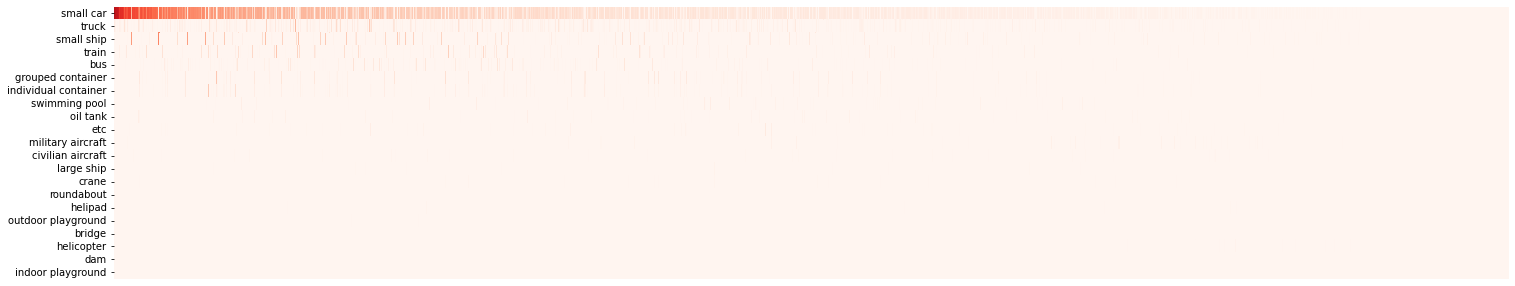

In [16]:
plt.figure(figsize = (25,5))
ax = sns.heatmap(df_img2obj.iloc[:,2:].transpose(), cmap='Reds', cbar=False, xticklabels=False)

### Objects per single Image
* 사진1장에 포함된 객체수의 분포
* 전체 분포와 'small car' 분포가 별 차이가 없음 ...

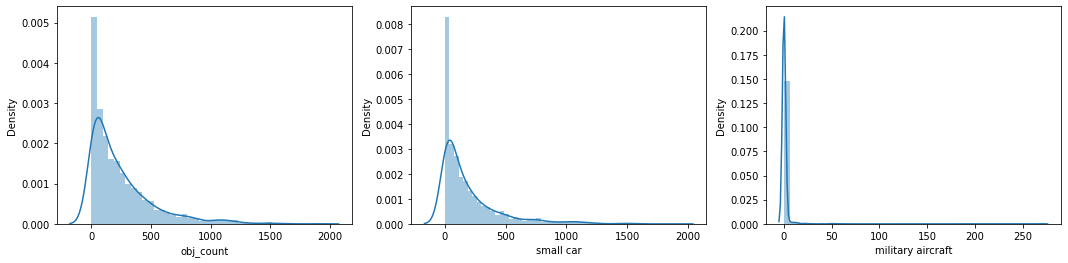

In [17]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
sns.distplot(df_img2obj['obj_count'], ax=axs[0])
sns.distplot(df_img2obj['small car'], ax=axs[1])
sns.distplot(df_img2obj['military aircraft'], ax=axs[2])
plt.show()

### Image에 포함된 고유한 객체유형수 1~10
* 고유한 객체유형(type_id)은 10개

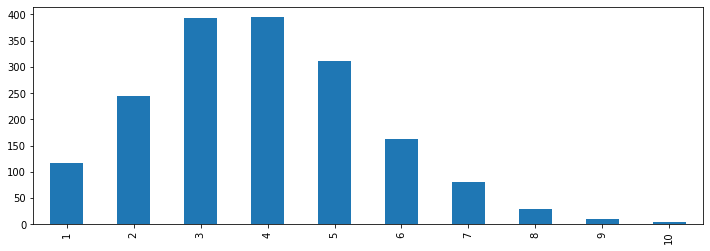

In [18]:
df_img2obj['obj_nunique'].value_counts().sort_index().plot.bar(figsize=(12,4))
plt.show()

## 객체유형별 전체 객체수(obj_count), 객체를 포함하는 이미지수(image_count)

In [19]:
df_object = df_train.type_name.value_counts().to_frame(name = 'obj_count')
df_object = df_object.join(df_train[['type_name','image_id']].drop_duplicates()['type_name'].value_counts()).rename(columns = {'type_name':'image_count'})
#df_object.plot.barh(figsize=(12,6))

In [20]:
df_object

,obj_count,image_count
small car,334199,1623
truck,27067,1317
small ship,19238,294
train,10331,154
bus,8698,827
grouped container,8069,322
individual container,5959,347
swimming pool,2188,194
oil tank,1631,117
etc,1542,230


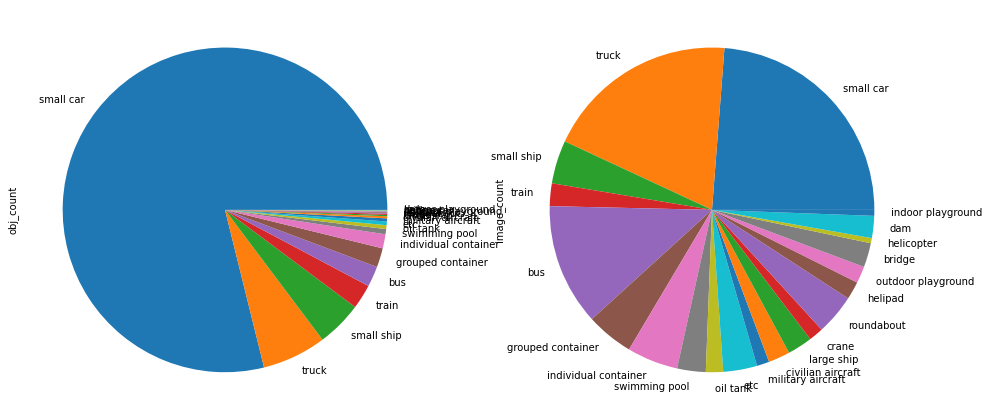

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
df_object['obj_count'].plot.pie(ax=axs[0])
df_object['image_count'].plot.pie(ax=axs[1])

### Split Object Coordinates

In [22]:
imcoords_columns = []
for i in range(4):
    df_train['p{}_x'.format(i+1)] = 0.0
    df_train['p{}_y'.format(i+1)] = 0.0
    imcoords_columns.append('p{}_x'.format(i+1))
    imcoords_columns.append('p{}_y'.format(i+1))

# Parse 'object_imcoords'
df_train[imcoords_columns] = df_train.apply(lambda x: list(map(float, x['object_imcoords'].split(','))), axis=1, result_type='expand')
df_train.head(3)

,image_id,type_id,type_name,object_angle,object_imcoords,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.016708,"909.9167741757478,162.581938933753,909.2048358...",909.916774,162.581939,909.204836,161.092600,917.764564,157.000853,918.476503,158.490193
1,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"913.0400862653505,168.7304042851768,912.285894...",913.040086,168.730404,912.285894,167.262010,927.274976,159.563363,928.029169,161.031758
2,OBJ00013_PS3_K3_NIA0078.png,18,individual container,2.045278,"922.3328562982837,185.22684603509927,921.22870...",922.332856,185.226846,921.228703,183.077086,939.093852,173.901242,940.198005,176.051003


In [23]:
df_train['type_id'] = df_train['type_id'].astype(int)

df_types = df_train[['type_id','type_name']].drop_duplicates().sort_values(by='type_id').reset_index(drop=True)
df_types.index = df_types.index + 1

# type_id : type_name
type_name_dict = df_types['type_name'].to_dict()

# Object Type : Color (plt.cm.tab20b)
type_colors = dict(zip(type_name_dict.keys(), plt.cm.tab20.colors))

### Display Image & Objects
* 사진과 객체를 출력해주는 유틸리티 함수 

In [28]:
def show_n_mask(image_id, obj_type=None, gray_mode=True):
    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('/content/drive/MyDrive/sia/format/Objects/train/image/'+image_id, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in df_train[df_train.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():
        if (obj_type==row.type_name):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
    plt.show()

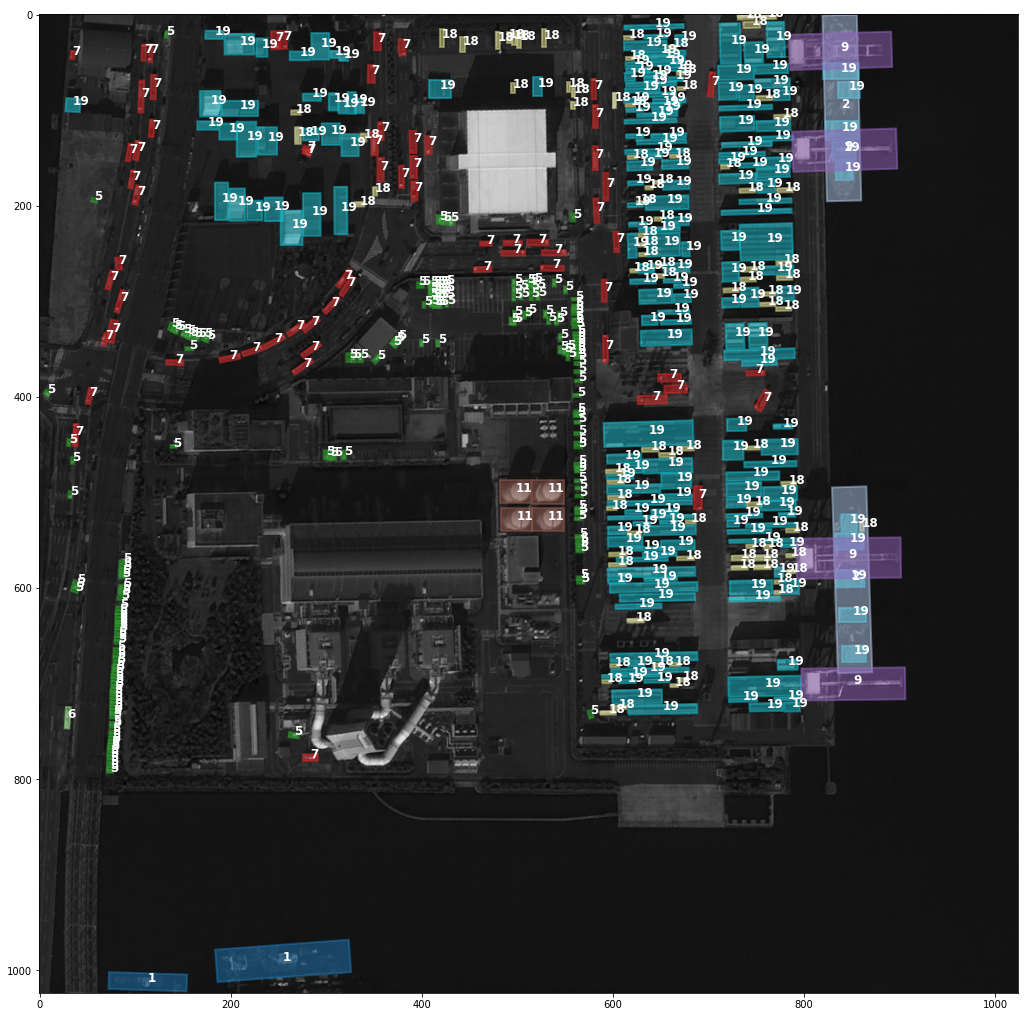

In [29]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png')

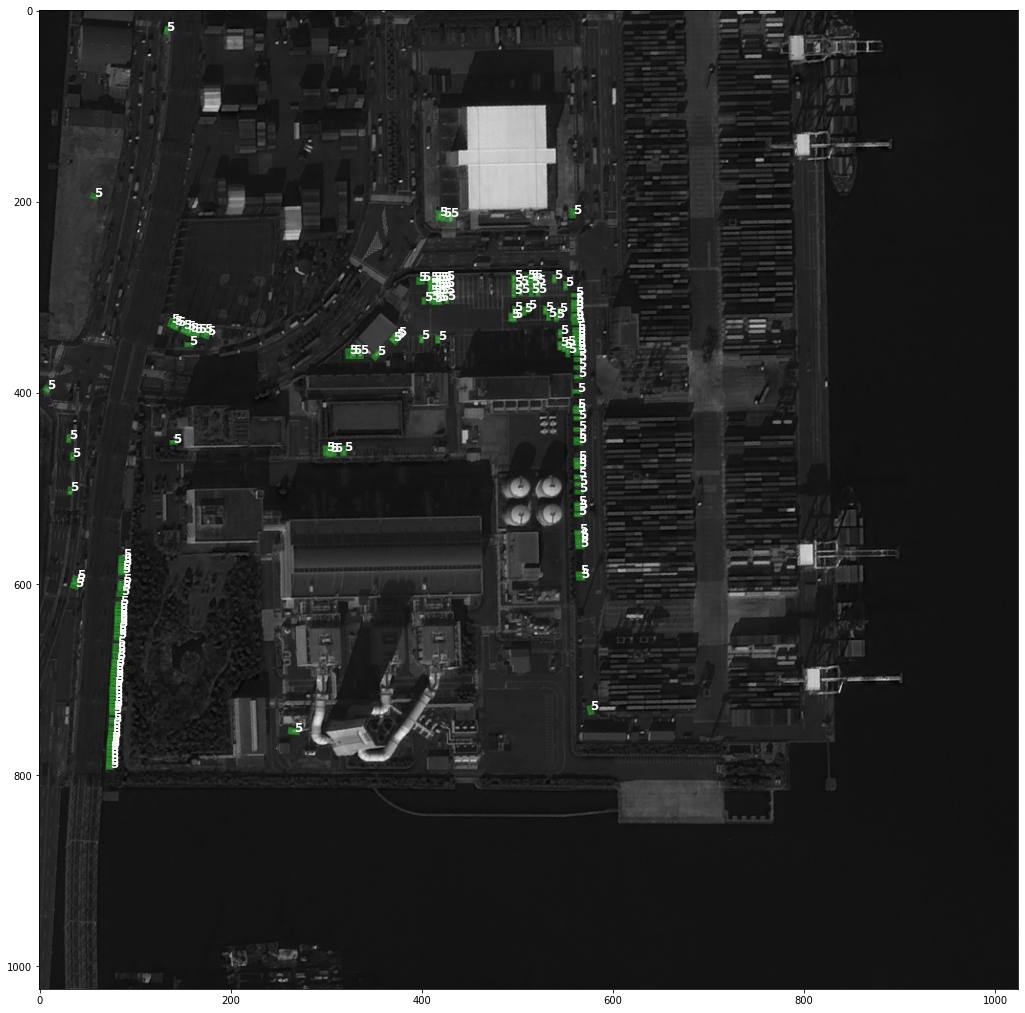

In [30]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png', 'small car')

#### Sample : 1 Object (1 bridge)

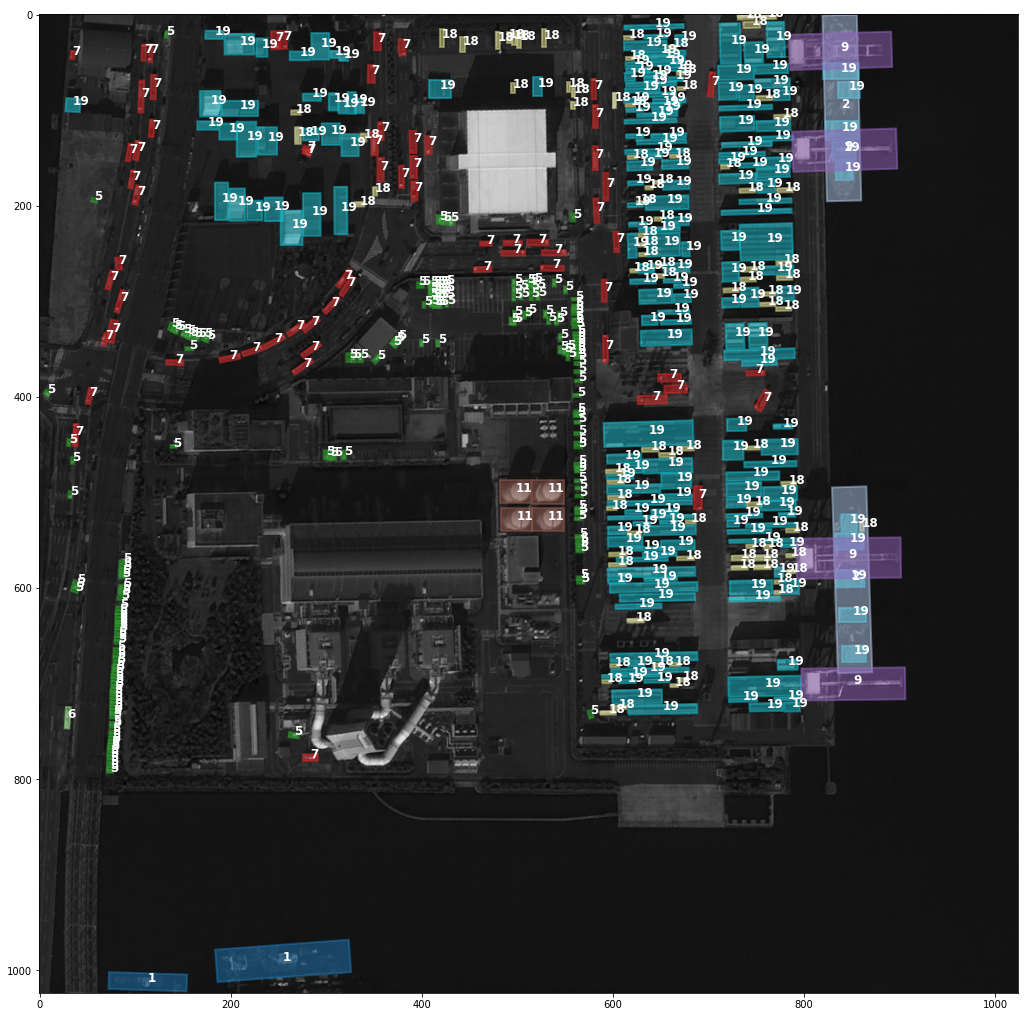

In [31]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png')

In [ ]:
# EOF